# DNN Model Training

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv # required for HalvingGridSearchCV
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from skopt import BayesSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, History
import matplotlib.pyplot as plt
import os
import pickle

# Raw PD Data

In [4]:
# import data from csv to dataframe
filename = "train_data/raw_data_pd.csv"
df = pd.read_csv(filename)
display(df)

# split into input and target features, and weights
X = df[['distance_to_road_center', 'angle_from_straight_in_rads']].values
y = df['steering_angle'].values
r = df['reward'].values

# normalize rewards to [0, 1] range
norm_r = (r - np.min(r)) / (np.max(r) - np.min(r))

# calculate weights based on normalized rewards
weights = np.where(r < 0, 1 / (1 - norm_r), 1 / (1 + norm_r))

# split into training and validation sets
Xtrain, Xval, ytrain, yval, wtrain, wval = train_test_split(X, y, weights, test_size=0.2, random_state=42)

,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,2.588463,1.026888,2.956561,-0.012300
1,2.588463,1.026888,2.956561,-0.012300
2,2.588463,1.026888,2.956561,-0.012300
3,2.588463,1.026888,2.956561,-0.012300
4,2.588463,1.026888,2.956561,-0.012614
...,...,...,...,...
124995,0.144081,0.147693,0.010285,-3.835282
124996,0.142465,0.148484,0.006000,-3.813875
124997,0.140811,0.149215,0.001745,-3.792289
124998,0.139120,0.149889,-0.002478,-3.770526


/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_99292/2548153325.py:15: RuntimeWarning: divide by zero encountered in divide
  weights = np.where(r < 0, 1 / (1 - norm_r), 1 / (1 + norm_r))


In [8]:
# find optimal number of epochs using early stopping

# define base model with default Huber loss delta = 1.0
model = Sequential([
    Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for steering angle prediction
])

model.compile(loss=Huber(delta=1.0), optimizer=Adam(learning_rate=0.001), weighted_metrics=[])

# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# fit the model
history = model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=100, batch_size=32, validation_data = (Xval, yval, wval), callbacks = [early_stop])

Epoch 1/100
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0311 - val_loss: 4.9459e-04
Epoch 2/100
3125/3125 [==============================] - 2s 533us/step - loss: 5.7531e-04 - val_loss: 7.1825e-04
Epoch 3/100
3125/3125 [==============================] - 2s 507us/step - loss: 4.4264e-04 - val_loss: 5.8055e-04
Epoch 4/100
3125/3125 [==============================] - 2s 522us/step - loss: 4.8484e-04 - val_loss: 3.8641e-05
Epoch 5/100
3125/3125 [==============================] - 2s 508us/step - loss: 2.5327e-04 - val_loss: 4.7775e-05
Epoch 6/100
3125/3125 [==============================] - 2s 521us/step - loss: 2.6589e-04 - val_loss: 2.4218e-04
Epoch 7/100
3125/3125 [==============================] - 2s 514us/step - loss: 2.0023e-04 - val_loss: 5.0007e-06
Epoch 8/100
3125/3125 [==============================] - 2s 511us/step - loss: 2.1890e-04 - val_loss: 6.4376e-06
Epoch 9/100
3125/3125 [==============================] - 2s 509us/step - loss: 1.4528e-04 - val_loss: 

In [10]:
# find best delta for loss function

# function to train and evaluate model with a given delta
def train_and_evaluate(delta, Xtrain, ytrain, wtrain, Xval, yval, wval):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=delta), metrics=['mae', 'mse'], weighted_metrics=[])

    history = model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval))

    # get validation MAE, MSE and Huber loss
    val_mae = history.history['val_mae'][-1]
    val_mse = history.history['val_mse'][-1]
    val_loss = history.history['val_loss'][-1]

    return val_mae, val_mse, val_loss

# initialise delta value and step size
delta = 0.5
step_size = 0.1
best_delta = delta
best_val_mae = float('inf')
best_val_mse = float('inf')

# initialise arrays for plotting
arr_val_mae = []
arr_val_mse = []
arr_val_loss = []

# iterative search for optimal delta
for i in range(10):
    val_mae, val_mse, val_loss = train_and_evaluate(delta, Xtrain, ytrain, wtrain, Xval, yval, wval)

    # print current results
    print(f"Iteration {i+1}: delta = {delta}, val_mae = {val_mae}, val_mse = {val_mse}")

    # update best delta if current results are better
    if val_mae < best_val_mae and val_mse < best_val_mse: 
        best_delta = delta
        best_val_mae = val_mae
        best_val_mse = val_mse
    
    # store data
    arr_val_mae.append(val_mae)
    arr_val_mse.append(val_mse)
    arr_val_loss.append(val_loss)
    
    # adjust delta for next iteration 
    delta += step_size


Epoch 1/11
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0202 - mae: 0.0251 - mse: 0.0104 - val_loss: 1.5993e-04 - val_mae: 0.0052 - val_mse: 6.3100e-05
Epoch 2/11
3125/3125 [==============================] - 2s 537us/step - loss: 7.1293e-04 - mae: 0.0093 - mse: 2.6307e-04 - val_loss: 0.0031 - val_mae: 0.0230 - val_mse: 9.9338e-04
Epoch 3/11
3125/3125 [==============================] - 2s 541us/step - loss: 5.7935e-04 - mae: 0.0097 - mse: 2.3994e-04 - val_loss: 6.5062e-04 - val_mae: 0.0123 - val_mse: 3.5072e-04
Epoch 4/11
3125/3125 [==============================] - 2s 538us/step - loss: 4.6699e-04 - mae: 0.0089 - mse: 2.1845e-04 - val_loss: 7.2402e-05 - val_mae: 0.0046 - val_mse: 4.5898e-05
Epoch 5/11
3125/3125 [==============================] - 2s 568us/step - loss: 2.8915e-04 - mae: 0.0068 - mse: 1.2366e-04 - val_loss: 2.7315e-05 - val_mae: 0.0033 - val_mse: 1.6124e-05
Epoch 6/11
3125/3125 [==============================] - 2s 539us/step - loss: 2.4844e-04 - mae

Best delta: 0.7
Best validation MAE: 0.0008989019552245736
Best validation MSE: 1.7142334627351374e-06


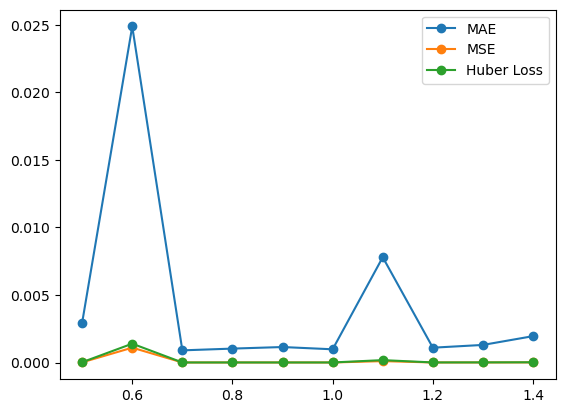

In [11]:
# plot results
deltas = np.arange(0.5, 1.5, 0.1)
plt.plot(deltas, arr_val_mae, marker='o', linestyle='-', color='C0', label='MAE')
plt.plot(deltas, arr_val_mse, marker='o', linestyle='-', color='C1', label='MSE')
plt.plot(deltas, arr_val_loss, marker='o', linestyle='-', color='C2', label='Huber Loss')
plt.legend()

print(f"Best delta: {best_delta}")
print(f"Best validation MAE: {best_val_mae}")
print(f"Best validation MSE: {best_val_mse}")

## Base Model

In [13]:
# evaluate base model 
base_model = Sequential([
                    Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
                    Dense(32, activation='relu'),
                    Dense(1)
])

base_model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=best_delta), weighted_metrics=[])

history = base_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval), callbacks=[history])

# create folder for models
if not os.path.exists("models"):
    os.makedirs("models")

# save model
base_model.save("models/base_dnn_model_raw_pd.h5")

# save model history
with open('models/base_dnn_model_raw_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# print results
base_train_hl = history.history["loss"][-1]
base_val_hl = history.history["val_loss"][-1]
print(f"Training Huber Loss: {base_train_hl}")
print(f"Validation Huber Loss: {base_val_hl}")

Epoch 1/21
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0124 - val_loss: 1.4695e-04
Epoch 2/21
3125/3125 [==============================] - 2s 503us/step - loss: 7.0489e-04 - val_loss: 3.3615e-04
Epoch 3/21
3125/3125 [==============================] - 2s 513us/step - loss: 4.8774e-04 - val_loss: 1.1937e-04
Epoch 4/21
3125/3125 [==============================] - 2s 503us/step - loss: 2.9723e-04 - val_loss: 4.5692e-05
Epoch 5/21
3125/3125 [==============================] - 2s 512us/step - loss: 2.7682e-04 - val_loss: 2.9324e-04
Epoch 6/21
3125/3125 [==============================] - 2s 513us/step - loss: 2.5597e-04 - val_loss: 8.6236e-05
Epoch 7/21
3125/3125 [==============================] - 2s 507us/step - loss: 1.9329e-04 - val_loss: 5.5759e-05
Epoch 8/21
3125/3125 [==============================] - 2s 517us/step - loss: 1.1497e-04 - val_loss: 2.0861e-04
Epoch 9/21
3125/3125 [==============================] - 2s 511us/step - loss: 1.6720e-04 - val_loss: 1.1083e-0

## Regularised Model

In [14]:
# evaluate regularised model
reg_model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],), kernel_regularizer='l2'), 
        Dense(32, activation='relu', kernel_regularizer='l2'),
        Dense(1)
    ])

reg_model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=best_delta), weighted_metrics=[])

history = reg_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval), callbacks=[history])

Epoch 1/21
3125/3125 [==============================] - 4s 1ms/step - loss: 0.1233 - val_loss: 0.0321
Epoch 2/21
3125/3125 [==============================] - 2s 538us/step - loss: 0.0195 - val_loss: 0.0155
Epoch 3/21
3125/3125 [==============================] - 2s 546us/step - loss: 0.0136 - val_loss: 0.0111
Epoch 4/21
3125/3125 [==============================] - 2s 548us/step - loss: 0.0106 - val_loss: 0.0088
Epoch 5/21
3125/3125 [==============================] - 2s 537us/step - loss: 0.0085 - val_loss: 0.0072
Epoch 6/21
3125/3125 [==============================] - 2s 563us/step - loss: 0.0073 - val_loss: 0.0059
Epoch 7/21
3125/3125 [==============================] - 2s 548us/step - loss: 0.0085 - val_loss: 0.0135
Epoch 8/21
3125/3125 [==============================] - 2s 525us/step - loss: 0.0057 - val_loss: 0.0080
Epoch 9/21
3125/3125 [==============================] - 2s 533us/step - loss: 0.0068 - val_loss: 0.0050
Epoch 10/21
3125/3125 [==============================] - 2s 546us/

In [15]:
# save model
base_model.save("models/reg_dnn_model_raw_pd.h5")

# save model history
with open('models/reg_dnn_model_raw_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# print results
reg_train_hl = history.history["loss"][-1]
reg_val_hl = history.history["val_loss"][-1]
print(f"Training Huber Loss: {reg_train_hl}")
print(f"Validation Huber Loss: {reg_val_hl}")

Training Huber Loss: 0.00447514234110713
Validation Huber Loss: 0.003721917513757944


## Best Model

In [34]:
# define base model function for bayes search
def create_model(activation='relu', optimizer='adam', learning_rate=0.001, kernel_regularizer=None, batch_size=32):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    # compile model
    optimizer = Adam(learning_rate=learning_rate) if optimizer == 'adam' else optimizer

    model.compile(optimizer=optimizer, loss=Huber(delta=best_delta), weighted_metrics=[])

    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=batch_size, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'activation': ['relu', 'tanh'],
    'optimizer': ['sgd', 'adam'],
    'learning_rate': [0.001, 0.01, 0.1],
    'kernel_regularizer': ['l1', 'l2', 'l1_l2'],
    'batch_size': [16, 32, 64]
}

# create a KerasRegressor wrapper
keras_reg = KerasRegressor(build_fn=create_model, epochs=early_stop.stopped_epochs, verbose=2)

# perform random search hyperparameter tuning
bayes_search = BayesSearchCV(estimator=keras_reg, search_spaces=param_dist, n_iter=10, cv=5, verbose=2, random_state=42, error_score='raise')
bayes_search.fit(Xtrain, ytrain, sample_weight=wtrain, validation_data=(Xval, yval, wval))

/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_95306/2299525531.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/21
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3913 - val_loss: 0.0504
Epoch 2/21
1563/1563 [==============================] - 1s 554us/step - loss: 0.0354 - val_loss: 0.0248
Epoch 3/21
1563/1563 [==============================] - 1s 552us/step - loss: 0.0214 - val_loss: 0.0172
Epoch 4/21
1563/1563 [==============================] - 1s 572us/step - loss: 0.0180 - val_loss: 0.0160
Epoch 5/21
1563/1563 [==============================] - 1s 550us/step - loss: 0.0132 - val_loss: 0.0119
Epoch 6/21
1563/1563 [==============================] - 1s 552us/step - loss: 0.0118 - val_loss: 0.0102
Epoch 7/21
1563/1563 [==============================] - 1s 569us/step - loss: 0.0102 - val_loss: 0.0092
Epoch 8/21
1563/1563 [==============================] - 1s 556us/step - loss: 0.0093 - val_loss: 0.0084
Epoch 9/21
1563/1563 [==============================] - 1s 639us/step - loss: 0.0085 - val_loss: 0.0077
Epoch 1

BayesSearchCV(cv=5,
              estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x32b1abe20>,
              n_iter=10, random_state=42,
              search_spaces={'activation': ['relu', 'tanh'],
                             'batch_size': [16, 32, 64],
                             'kernel_regularizer': ['l1', 'l2', 'l1_l2'],
                             'learning_rate': [0.001, 0.01, 0.1],
                             'optimizer': ['sgd', 'adam']},
              verbose=2)

In [35]:
bayes_search_df = pd.DataFrame(bayes_search.cv_results_)

display(bayes_search_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_kernel_regularizer,param_learning_rate,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,48.897756,0.870543,0.156242,0.011116,relu,64,l1_l2,0.001,adam,"{'activation': 'relu', 'batch_size': 64, 'kern...",-0.004013,-0.003887,-0.003985,-0.004065,-0.004182,-0.004026,0.000097,2
1,47.712921,0.397587,0.144377,0.003170,tanh,64,l1,0.1,adam,"{'activation': 'tanh', 'batch_size': 64, 'kern...",-0.920400,-0.372206,-0.663099,-0.555351,-0.749872,-0.652185,0.184047,9
2,42.110752,1.256021,0.151572,0.010048,relu,64,l1,0.01,sgd,"{'activation': 'relu', 'batch_size': 64, 'kern...",-0.006722,-0.005950,-0.007479,-0.006512,-0.006029,-0.006538,0.000552,4
3,135.101206,0.380900,0.378550,0.007319,tanh,16,l2,0.1,adam,"{'activation': 'tanh', 'batch_size': 16, 'kern...",-1.221039,-2.241018,-2.258673,-1.308517,-1.526313,-1.711112,0.451005,10
4,76.599411,0.461664,0.228074,0.008765,tanh,32,l2,0.1,adam,"{'activation': 'tanh', 'batch_size': 32, 'kern...",-0.551183,-0.671337,-0.275650,-0.343786,-0.761923,-0.520776,0.186095,7
5,49.627714,0.804522,0.150416,0.005282,tanh,64,l1,0.001,adam,"{'activation': 'tanh', 'batch_size': 64, 'kern...",-0.011203,-0.010994,-0.012591,-0.012352,-0.013580,-0.012144,0.000950,5
6,49.005421,0.492690,0.149297,0.007677,tanh,64,l2,0.1,adam,"{'activation': 'tanh', 'batch_size': 64, 'kern...",-0.624877,-0.266007,-0.635726,-0.305873,-1.075089,-0.581515,0.291190,8
7,43.598086,0.795214,0.150025,0.006603,tanh,64,l2,0.1,sgd,"{'activation': 'tanh', 'batch_size': 64, 'kern...",-0.002285,-0.002225,-0.002348,-0.002100,-0.002193,-0.002230,0.000084,1
8,43.600693,0.447184,0.152037,0.005516,tanh,64,l1_l2,0.01,sgd,"{'activation': 'tanh', 'batch_size': 64, 'kern...",-0.041846,-0.029398,-0.051953,-0.034058,-0.031372,-0.037725,0.008277,6
9,50.836121,0.821611,0.152331,0.004190,relu,64,l1_l2,0.001,adam,"{'activation': 'relu', 'batch_size': 64, 'kern...",-0.004155,-0.004024,-0.004070,-0.003794,-0.004121,-0.004033,0.000127,3


In [14]:
# grid search selected hyperparameters

# define base model function for grid search
def create_model(activation='relu', optimizer='adam', kernel_regularizer='l2', batch_size=64):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    model.compile(optimizer=optimizer, loss=Huber(delta=best_delta), weighted_metrics=[])

    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=batch_size, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'optimizer': ['sgd', Adam(learning_rate=0.001), Adam(learning_rate=0.01), Adam(learning_rate=0.1)],
    'kernel_regularizer': ['l1', 'l2', 'l1_l2'],
}

# create a KerasRegressor wrapper
keras_reg = KerasRegressor(build_fn=create_model, epochs=early_stop.stopped_epoch, verbose=2)

# perform grid search hyperparameter tuning
grid_search = HalvingGridSearchCV(estimator=keras_reg, param_grid=param_dist, cv=5, verbose=2, error_score='raise')
grid_search.fit(Xtrain, ytrain, sample_weight=wtrain)

/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_99292/3143193033.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=create_model, epochs=early_stop.stopped_epoch, verbose=2)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 11111
max_resources_: 100000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 11111
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/11
1563/1563 [==============================] - 3s 1ms/step - loss: 1.3465 - val_loss: 0.4055
Epoch 2/11
1563/1563 [==============================] - 1s 435us/step - loss: 0.1402 - val_loss: 0.0562
Epoch 3/11
1563/1563 [==============================] - 1s 428us/step - loss: 0.0448 - val_loss: 0.0366
Epoch 4/11
1563/1563 [==============================] - 1s 425us/step - loss: 0.0348 - val_loss: 0.0322
Epoch 5/11
1563/1563 [==============================] - 1s 427us/step - loss: 0.0338 - val_loss: 0.0500
Epoch 6/11
1563/1563 [==============================] - 1s 478us/step - loss: 0.0288 - val_loss: 0.0334
Epoch 7/11
1563/1563 [==============================] - 1s 494us/step - loss: 0.0286 - val_loss: 0.0230
Epoch 8

HalvingGridSearchCV(error_score='raise',
                    estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x31e2a4940>,
                    param_grid={'kernel_regularizer': ['l1', 'l2', 'l1_l2'],
                                'optimizer': ['sgd',
                                              <keras.optimizers.legacy.adam.Adam object at 0x31e2a44c0>,
                                              <keras.optimizers.legacy.adam.Adam object at 0x31e2a4a60>,
                                              <keras.optimizers.legacy.adam.Adam object at 0x31e2a4070>]},
                    verbose=2)

In [15]:
grid_search_df = pd.DataFrame(grid_search.cv_results_)

display(grid_search_df)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel_regularizer,param_optimizer,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,11111,16.997419,0.293825,0.079295,0.001660,l1,sgd,"{'kernel_regularizer': 'l1', 'optimizer': 'sgd'}",-0.014213,...,-0.012012,0.001611,14,-0.014210,-0.013634,-0.010464,-0.010404,-0.011347,-0.012012,0.001605
1,0,11111,19.082942,0.169986,0.081252,0.002900,l1,<keras.optimizers.legacy.adam.Adam object at 0...,"{'kernel_regularizer': 'l1', 'optimizer': <ker...",-0.005693,...,-0.005604,0.000223,10,-0.005692,-0.005540,-0.005397,-0.005991,-0.005397,-0.005604,0.000223
2,0,11111,19.774823,0.208586,0.081163,0.002130,l1,<keras.optimizers.legacy.adam.Adam object at 0...,"{'kernel_regularizer': 'l1', 'optimizer': <ker...",-0.026682,...,-0.027134,0.000823,15,-0.026685,-0.026955,-0.026410,-0.028737,-0.026886,-0.027135,0.000823
3,0,11111,19.576868,0.366474,0.079455,0.003233,l1,<keras.optimizers.legacy.adam.Adam object at 0...,"{'kernel_regularizer': 'l1', 'optimizer': <ker...",-0.251134,...,-0.249694,0.002871,17,-0.251033,-0.248961,-0.254116,-0.245601,-0.248622,-0.249666,0.002820
4,0,11111,17.627119,0.196109,0.079965,0.000889,l2,sgd,"{'kernel_regularizer': 'l2', 'optimizer': 'sgd'}",-0.002666,...,-0.002632,0.000044,7,-0.002665,-0.002537,-0.002637,-0.002655,-0.002661,-0.002631,0.000048
5,0,11111,19.685975,0.251114,0.078898,0.000797,l2,<keras.optimizers.legacy.adam.Adam object at 0...,"{'kernel_regularizer': 'l2', 'optimizer': <ker...",-0.001247,...,-0.001442,0.000451,5,-0.001248,-0.002222,-0.001386,-0.001109,-0.001138,-0.001421,0.000412
6,0,11111,19.925349,0.165671,0.079988,0.003639,l2,<keras.optimizers.legacy.adam.Adam object at 0...,"{'kernel_regularizer': 'l2', 'optimizer': <ker...",-0.001318,...,-0.003046,0.002154,8,-0.001318,-0.003359,-0.001547,-0.007301,-0.001889,-0.003083,0.002226
7,0,11111,20.040764,0.241711,0.079797,0.002502,l2,<keras.optimizers.legacy.adam.Adam object at 0...,"{'kernel_regularizer': 'l2', 'optimizer': <ker...",-0.005327,...,-0.009157,0.004497,12,-0.005273,-0.005871,-0.005183,-0.012737,-0.015338,-0.008880,0.004297
8,0,11111,17.926032,0.387758,0.083417,0.002099,l1_l2,sgd,"{'kernel_regularizer': 'l1_l2', 'optimizer': '...",-0.011382,...,-0.011686,0.000507,13,-0.011381,-0.012582,-0.011095,-0.011546,-0.011830,-0.011687,0.000507
9,0,11111,20.120462,0.067826,0.083020,0.001753,l1_l2,<keras.optimizers.legacy.adam.Adam object at 0...,"{'kernel_regularizer': 'l1_l2', 'optimizer': <...",-0.007023,...,-0.006413,0.000367,11,-0.007033,-0.006217,-0.005919,-0.006353,-0.006546,-0.006414,0.000371


In [17]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")

Best Parameters: {'kernel_regularizer': 'l2', 'optimizer': <keras.optimizers.legacy.adam.Adam object at 0x31e2a44c0>}


In [18]:
# grid search learning rates

# define base model function for grid search
def create_model(activation='relu', learning_rate=0.001, kernel_regularizer='l2', batch_size=64):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=Huber(delta=best_delta), weighted_metrics=[])

    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=batch_size, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'learning_rate': [0.001, 0.01, 0.1]
}

# create a KerasRegressor wrapper
keras_reg = KerasRegressor(build_fn=create_model, epochs=early_stop.stopped_epoch, verbose=2)

# perform grid search hyperparameter tuning
grid_search = HalvingGridSearchCV(estimator=keras_reg, param_grid=param_dist, cv=5, verbose=2, error_score='raise')
grid_search.fit(Xtrain, ytrain, sample_weight=wtrain)

/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_99292/377624069.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=create_model, epochs=early_stop.stopped_epoch, verbose=2)


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 33333
max_resources_: 100000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 33333
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Epoch 1/11
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1467 - val_loss: 0.0128
Epoch 2/11
1563/1563 [==============================] - 1s 568us/step - loss: 0.0077 - val_loss: 0.0043
Epoch 3/11
1563/1563 [==============================] - 1s 599us/step - loss: 0.0045 - val_loss: 0.0032
Epoch 4/11
1563/1563 [==============================] - 1s 588us/step - loss: 0.0032 - val_loss: 0.0068
Epoch 5/11
1563/1563 [==============================] - 1s 572us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 6/11
1563/1563 [==============================] - 1s 553us/step - loss: 0.0026 - val_loss: 0.0018
Epoch 7/11
1563/1563 [==============================] - 1s 551us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/1

HalvingGridSearchCV(error_score='raise',
                    estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x32572bb20>,
                    param_grid={'learning_rate': [0.001, 0.01, 0.1]},
                    verbose=2)

In [19]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")

Best Parameters: {'learning_rate': 0.01}


In [45]:
# evaluate best model
best_model = Sequential([
    Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dense(1)
])

best_model.compile(optimizer=Adam(learning_rate=0.01), loss=Huber(delta=best_delta), weighted_metrics=[])

history = best_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=64, validation_data=(Xval, yval, wval))

# save the best model
best_model.save("models/best_dnn_model_raw_pd.h5")

# save model history in models
with open('models/best_dnn_model_raw_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/11
1334/1334 [==============================] - 3s 2ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 2/11
1334/1334 [==============================] - 1s 629us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/11
1334/1334 [==============================] - 1s 586us/step - loss: 7.4837e-04 - val_loss: 2.9767e-04
Epoch 4/11
1334/1334 [==============================] - 1s 556us/step - loss: 7.7995e-04 - val_loss: 4.0676e-04
Epoch 5/11
1334/1334 [==============================] - 1s 633us/step - loss: 6.9497e-04 - val_loss: 0.0013
Epoch 6/11
1334/1334 [==============================] - 1s 609us/step - loss: 4.3383e-04 - val_loss: 2.5998e-04
Epoch 7/11
1334/1334 [==============================] - 1s 592us/step - loss: 4.0091e-04 - val_loss: 2.9744e-04
Epoch 8/11
1334/1334 [==============================] - 1s 553us/step - loss: 4.1961e-04 - val_loss: 2.0497e-04
Epoch 9/11
1334/1334 [==============================] - 1s 553us/step - loss: 4.5444e-04 - val_loss: 6.9645e-04
Epoch 10/11
13

Best Training Huber Loss: 0.00033411901677027345
Best Validation Huber Loss: 0.0004400824836920947


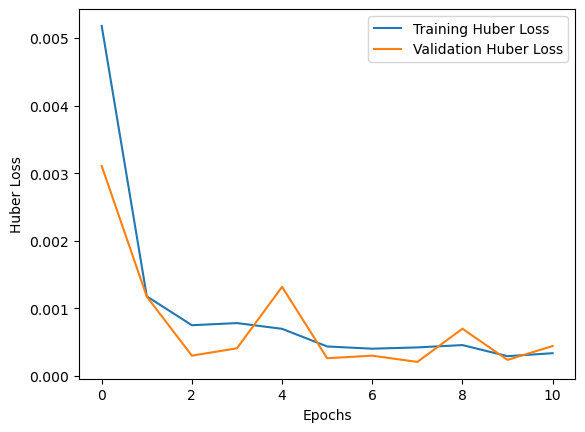

In [46]:
best_train_hl = best_model.history.history["loss"][-1]
best_val_hl = best_model.history.history["val_loss"][-1]
print(f"Best Training Huber Loss: {best_train_hl}")
print(f"Best Validation Huber Loss: {best_val_hl}")

plt.plot(best_model.history.history['loss'], label='Training Huber Loss')
plt.plot(best_model.history.history['val_loss'], label='Validation Huber Loss')
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')
plt.legend()
plt.show()

# Processed PD Data

In [5]:
# import data from csv to dataframe
filename = "processed_data_pd.csv"
df = pd.read_csv(f"train_data/{filename}")
display(df)

# split into input and target features
X = df[['distance_to_road_center', 'angle_from_straight_in_rads']].values
y = df['steering_angle'].values
r = df['reward'].values

# normalize rewards to [0, 1] range
norm_r = (r - np.min(r)) / (np.max(r) - np.min(r))

# calculate weights based on normalized rewards
weights = np.where(r < 0, 1 / (1 - norm_r), 1 / (1 + norm_r))

# split into training and validation sets
Xtrain, Xval, ytrain, yval, wtrain, wval = train_test_split(X, y, weights, test_size=0.2, random_state=42)

,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,-3.411134,-3.017721,-1.561374,-2.491427
1,-3.411134,-3.017721,-1.561374,-2.491427
2,-3.411134,-3.017721,-1.561374,-2.491427
3,-3.411134,-3.017721,-1.561374,-2.491427
4,-3.411134,-3.017721,-1.561374,-2.493814
...,...,...,...,...
106692,1.952193,-0.279947,3.417991,-0.491446
106693,1.990733,-0.220655,3.403938,-1.018409
106694,2.028543,-0.161769,3.389249,-1.523784
106695,2.046814,-0.103238,3.344323,-2.048647


/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_8512/1201342029.py:15: RuntimeWarning: divide by zero encountered in divide
  weights = np.where(r < 0, 1 / (1 - norm_r), 1 / (1 + norm_r))


In [6]:
# find optimal number of epochs using early stopping

# define base model with default Huber loss delta = 1.0
model = Sequential([
    Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for steering angle prediction
])

model.compile(loss=Huber(delta=1.0), optimizer=Adam(learning_rate=0.001), weighted_metrics=[])

# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# fit the model
history = model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=100, batch_size=32, validation_data = (Xval, yval, wval), callbacks = [early_stop])

Epoch 1/100
2668/2668 [==============================] - 4s 1ms/step - loss: 0.0054 - val_loss: 6.8445e-06
Epoch 2/100
2668/2668 [==============================] - 2s 601us/step - loss: 5.1792e-05 - val_loss: 3.2254e-05
Epoch 3/100
2668/2668 [==============================] - 2s 585us/step - loss: 3.4715e-05 - val_loss: 3.9242e-06
Epoch 4/100
2668/2668 [==============================] - 2s 584us/step - loss: 4.0076e-05 - val_loss: 6.3188e-06
Epoch 5/100
2668/2668 [==============================] - 2s 582us/step - loss: 2.8702e-05 - val_loss: 2.9887e-05
Epoch 6/100
2668/2668 [==============================] - 2s 588us/step - loss: 2.9418e-05 - val_loss: 6.9034e-06
Epoch 7/100
2668/2668 [==============================] - 2s 611us/step - loss: 2.1019e-05 - val_loss: 3.1088e-06
Epoch 8/100
2668/2668 [==============================] - 2s 589us/step - loss: 1.7690e-05 - val_loss: 2.2898e-06
Epoch 9/100
2668/2668 [==============================] - 2s 582us/step - loss: 1.2861e-05 - val_loss: 

In [7]:
# find best delta for loss function

# function to train and evaluate model with a given delta
def train_and_evaluate(delta, Xtrain, ytrain, wtrain, Xval, yval, wval):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=delta), metrics=['mae', 'mse'], weighted_metrics=[])

    history = model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval))

    # get validation MAE, MSE and Huber loss
    val_mae = history.history['val_mae'][-1]
    val_mse = history.history['val_mse'][-1]
    val_loss = history.history['val_loss'][-1]

    return val_mae, val_mse, val_loss

# initialise delta value and step size
delta = 0.5
step_size = 0.1
best_delta = delta
best_val_mae = float('inf')
best_val_mse = float('inf')

# initialise arrays for plotting
arr_val_mae = []
arr_val_mse = []
arr_val_loss = []

# iterative search for optimal delta
for i in range(10):
    val_mae, val_mse, val_loss = train_and_evaluate(delta, Xtrain, ytrain, wtrain, Xval, yval, wval)

    # print current results
    print(f"Iteration {i+1}: delta = {delta}, val_mae = {val_mae}, val_mse = {val_mse}")

    # update best delta if current results are better
    if val_mae < best_val_mae and val_mse < best_val_mse: 
        best_delta = delta
        best_val_mae = val_mae
        best_val_mse = val_mse
    
    # store data
    arr_val_mae.append(val_mae)
    arr_val_mse.append(val_mse)
    arr_val_loss.append(val_loss)
    
    # adjust delta for next iteration 
    delta += step_size


Epoch 1/20
2668/2668 [==============================] - 4s 1ms/step - loss: 0.0027 - mae: 0.0117 - mse: 0.0057 - val_loss: 2.8208e-06 - val_mae: 0.0014 - val_mse: 4.5744e-06
Epoch 2/20
2668/2668 [==============================] - 2s 627us/step - loss: 3.0040e-05 - mae: 0.0038 - mse: 4.2629e-05 - val_loss: 4.6602e-05 - val_mae: 0.0069 - val_mse: 6.5786e-05
Epoch 3/20
2668/2668 [==============================] - 2s 631us/step - loss: 3.2924e-05 - mae: 0.0041 - mse: 4.6376e-05 - val_loss: 1.7812e-05 - val_mae: 0.0046 - val_mse: 2.5883e-05
Epoch 4/20
2668/2668 [==============================] - 2s 655us/step - loss: 2.3937e-05 - mae: 0.0034 - mse: 3.3742e-05 - val_loss: 2.3363e-06 - val_mae: 0.0014 - val_mse: 3.9998e-06
Epoch 5/20
2668/2668 [==============================] - 2s 663us/step - loss: 1.8774e-05 - mae: 0.0028 - mse: 2.6222e-05 - val_loss: 1.2047e-05 - val_mae: 0.0031 - val_mse: 1.5800e-05
Epoch 6/20
2668/2668 [==============================] - 2s 638us/step - loss: 1.6471e-05 -

Best delta: 1.2
Best validation MAE: 0.00029089985764585435
Best validation MSE: 1.8254846168019867e-07


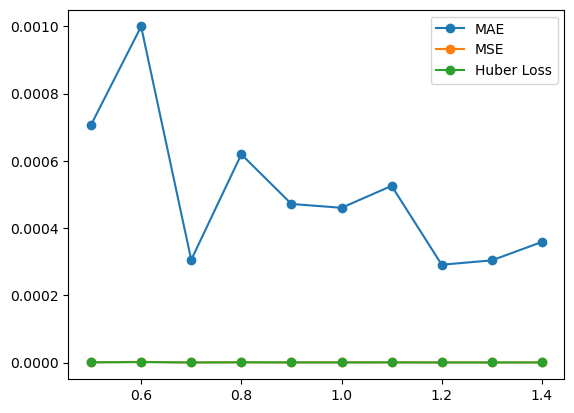

In [8]:
# plot results
deltas = np.arange(0.5, 1.5, 0.1)
plt.plot(deltas, arr_val_mae, marker='o', linestyle='-', color='C0', label='MAE')
plt.plot(deltas, arr_val_mse, marker='o', linestyle='-', color='C1', label='MSE')
plt.plot(deltas, arr_val_loss, marker='o', linestyle='-', color='C2', label='Huber Loss')
plt.legend()

print(f"Best delta: {best_delta}")
print(f"Best validation MAE: {best_val_mae}")
print(f"Best validation MSE: {best_val_mse}")

## Base Model

In [9]:
# evaluate base model 
base_model = Sequential([
    Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
    Dense(32, activation='relu'),
    Dense(1)
])

base_model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=best_delta), weighted_metrics=[])

history = base_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval), callbacks=[history])

# save model
base_model.save("models/base_dnn_model_processed_pd.h5")

# save model history
with open('models/base_dnn_model_processed_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# print results
base_train_hl = history.history["loss"][-1]
base_val_hl = history.history["val_loss"][-1]
print(f"Training Huber Loss: {base_train_hl}")
print(f"Validation Huber Loss: {base_val_hl}")

Epoch 1/20
2668/2668 [==============================] - 3s 1ms/step - loss: 0.0052 - val_loss: 6.1077e-06
Epoch 2/20
2668/2668 [==============================] - 2s 564us/step - loss: 1.2979e-05 - val_loss: 2.8237e-05
Epoch 3/20
2668/2668 [==============================] - 1s 561us/step - loss: 3.9175e-05 - val_loss: 9.9009e-06
Epoch 4/20
2668/2668 [==============================] - 2s 570us/step - loss: 2.8132e-05 - val_loss: 2.3209e-05
Epoch 5/20
2668/2668 [==============================] - 2s 563us/step - loss: 2.0126e-05 - val_loss: 5.8459e-06
Epoch 6/20
2668/2668 [==============================] - 2s 568us/step - loss: 1.8011e-05 - val_loss: 1.3920e-05
Epoch 7/20
2668/2668 [==============================] - 2s 569us/step - loss: 2.2421e-05 - val_loss: 1.0035e-05
Epoch 8/20
2668/2668 [==============================] - 2s 563us/step - loss: 9.1726e-06 - val_loss: 5.9296e-05
Epoch 9/20
2668/2668 [==============================] - 2s 563us/step - loss: 1.0892e-05 - val_loss: 8.4594e-0

## Regularised Model

In [10]:
# evaluate regularised model
reg_model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],), kernel_regularizer='l2'), 
        Dense(32, activation='relu', kernel_regularizer='l2'),
        Dense(1)
    ])

reg_model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=best_delta), weighted_metrics=[])
history = reg_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval), callbacks=[history])

# save model
base_model.save("models/reg_dnn_model_processed_pd.h5")

# save model history
with open('models/reg_dnn_model_processed_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# print results
reg_train_hl = history.history["loss"][-1]
reg_val_hl = history.history["val_loss"][-1]
print(f"Training Huber Loss: {reg_train_hl}")
print(f"Validation Huber Loss: {reg_val_hl}")

Epoch 1/20
2668/2668 [==============================] - 4s 1ms/step - loss: 0.0476 - val_loss: 0.0066
Epoch 2/20
2668/2668 [==============================] - 2s 583us/step - loss: 0.0053 - val_loss: 0.0045
Epoch 3/20
2668/2668 [==============================] - 2s 582us/step - loss: 0.0041 - val_loss: 0.0038
Epoch 4/20
2668/2668 [==============================] - 2s 589us/step - loss: 0.0036 - val_loss: 0.0033
Epoch 5/20
2668/2668 [==============================] - 2s 583us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 6/20
2668/2668 [==============================] - 2s 582us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
2668/2668 [==============================] - 2s 590us/step - loss: 0.0029 - val_loss: 0.0027
Epoch 8/20
2668/2668 [==============================] - 2s 579us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/20
2668/2668 [==============================] - 2s 583us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 10/20
2668/2668 [==============================] - 2s 590us/

## Best Model

In [11]:
# define base model function for bayes search
def create_model(activation='relu', optimizer='adam', learning_rate=0.001, kernel_regularizer=None, batch_size=32):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    # compile model
    optimizer = Adam(learning_rate=learning_rate) if optimizer == 'adam' else optimizer

    model.compile(optimizer=optimizer, loss=Huber(delta=best_delta), weighted_metrics=[])

    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=batch_size, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'activation': ['relu', 'tanh'],
    'optimizer': ['sgd', 'adam'],
    'learning_rate': [0.001, 0.01, 0.1],
    'kernel_regularizer': ['l1', 'l2', 'l1_l2'],
    'batch_size': [16, 32, 64]
}

# create a KerasRegressor wrapper
keras_reg = KerasRegressor(build_fn=create_model, epochs=early_stop.stopped_epoch, verbose=2)

# perform random search hyperparameter tuning
bayes_search = BayesSearchCV(estimator=keras_reg, search_spaces=param_dist, n_iter=10, cv=5, verbose=2, random_state=42, error_score='raise')
bayes_search.fit(Xtrain, ytrain, sample_weight=wtrain, validation_data=(Xval, yval, wval))

/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_8512/1497506516.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=create_model, epochs=early_stop.stopped_epoch, verbose=2)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/20
1334/1334 [==============================] - 3s 2ms/step - loss: 0.2728 - val_loss: 0.0211
Epoch 2/20
1334/1334 [==============================] - 1s 648us/step - loss: 0.0131 - val_loss: 0.0092
Epoch 3/20
1334/1334 [==============================] - 1s 634us/step - loss: 0.0079 - val_loss: 0.0068
Epoch 4/20
1334/1334 [==============================] - 1s 627us/step - loss: 0.0062 - val_loss: 0.0056
Epoch 5/20
1334/1334 [==============================] - 1s 634us/step - loss: 0.0053 - val_loss: 0.0050
Epoch 6/20
1334/1334 [==============================] - 1s 657us/step - loss: 0.0048 - val_loss: 0.0045
Epoch 7/20
1334/1334 [==============================] - 1s 632us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 8/20
1334/1334 [==============================] - 1s 633us/step - loss: 0.0042 - val_loss: 0.0040
Epoch 9/20
1334/1334 [==============================] - 1s 619us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 1

BayesSearchCV(cv=5,
              estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x317289cd0>,
              n_iter=10, random_state=42,
              search_spaces={'activation': ['relu', 'tanh'],
                             'batch_size': [16, 32, 64],
                             'kernel_regularizer': ['l1', 'l2', 'l1_l2'],
                             'learning_rate': [0.001, 0.01, 0.1],
                             'optimizer': ['sgd', 'adam']},
              verbose=2)

In [12]:
bayes_search_df = pd.DataFrame(bayes_search.cv_results_)

display(bayes_search_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_kernel_regularizer,param_learning_rate,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,83.505213,45.772704,0.254974,0.142270,relu,64,l1_l2,0.001,adam,"{'activation': 'relu', 'batch_size': 64, 'kern...",-0.002796,-0.002730,-0.002799,-0.002793,-0.002795,-0.002783,0.000026,2
1,54.452278,11.530733,0.171502,0.008555,tanh,64,l1,0.1,adam,"{'activation': 'tanh', 'batch_size': 64, 'kern...",-0.269539,-0.289035,-0.267694,-0.242272,-0.258110,-0.265330,0.015291,10
2,41.991496,0.848519,0.167091,0.001235,relu,64,l1,0.01,sgd,"{'activation': 'relu', 'batch_size': 64, 'kern...",-0.006232,-0.006389,-0.005917,-0.006209,-0.006068,-0.006163,0.000160,5
3,132.749105,2.708723,0.390171,0.018474,tanh,16,l2,0.1,adam,"{'activation': 'tanh', 'batch_size': 16, 'kern...",-0.151107,-0.143950,-0.274928,-0.310833,-0.139528,-0.204069,0.073491,9
4,76.800706,1.794140,0.255131,0.009214,tanh,32,l2,0.1,adam,"{'activation': 'tanh', 'batch_size': 32, 'kern...",-0.076903,-0.165621,-0.148347,-0.110676,-0.400030,-0.180315,0.114067,8
5,47.685086,0.784581,0.168622,0.013626,tanh,64,l1,0.001,adam,"{'activation': 'tanh', 'batch_size': 64, 'kern...",-0.005406,-0.005187,-0.005390,-0.005070,-0.005279,-0.005267,0.000126,4
6,47.084572,0.752071,0.170252,0.014930,tanh,64,l2,0.1,adam,"{'activation': 'tanh', 'batch_size': 64, 'kern...",-0.077937,-0.387723,-0.083635,-0.050334,-0.084537,-0.136833,0.126065,7
7,42.273023,0.395488,0.167234,0.005081,tanh,64,l2,0.1,sgd,"{'activation': 'tanh', 'batch_size': 64, 'kern...",-0.001617,-0.001884,-0.001595,-0.001792,-0.001818,-0.001741,0.000114,1
8,36.761418,3.757783,0.144581,0.006500,tanh,64,l1_l2,0.01,sgd,"{'activation': 'tanh', 'batch_size': 64, 'kern...",-0.020660,-0.020468,-0.020449,-0.021147,-0.021387,-0.020822,0.000378,6
9,40.125172,0.551569,0.137422,0.003076,relu,64,l1_l2,0.001,adam,"{'activation': 'relu', 'batch_size': 64, 'kern...",-0.003582,-0.003393,-0.002792,-0.002813,-0.002806,-0.003077,0.000340,3


In [13]:
# grid search selected hyperparameters

# define base model function for grid search
def create_model(activation='relu', kernel_regularizer='l2'):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    model.compile(optimizer=Adam(0.001), loss=Huber(delta=best_delta), weighted_metrics=[])
    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=64, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'activation': ['tanh', 'relu'],
    'kernel_regularizer': ['l1', 'l2', 'l1_l2']
}

# create a KerasRegressor wrapper
keras_reg = KerasRegressor(build_fn=create_model, epochs=early_stop.stopped_epoch, verbose=2)

# perform grid search hyperparameter tuning
grid_search = HalvingGridSearchCV(estimator=keras_reg, param_grid=param_dist, cv=5, verbose=2, error_score='raise')
grid_search.fit(Xtrain, ytrain, sample_weight=wtrain)

/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_8512/3282579545.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=create_model, epochs=early_stop.stopped_epoch, verbose=2)


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 28452
max_resources_: 85357
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 28452
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Epoch 1/20
1334/1334 [==============================] - 2s 2ms/step - loss: 0.2702 - val_loss: 0.0429
Epoch 2/20
1334/1334 [==============================] - 1s 608us/step - loss: 0.0366 - val_loss: 0.0324
Epoch 3/20
1334/1334 [==============================] - 1s 585us/step - loss: 0.0294 - val_loss: 0.0283
Epoch 4/20
1334/1334 [==============================] - 1s 570us/step - loss: 0.0253 - val_loss: 0.0239
Epoch 5/20
1334/1334 [==============================] - 1s 582us/step - loss: 0.0223 - val_loss: 0.0206
Epoch 6/20
1334/1334 [==============================] - 1s 584us/step - loss: 0.0194 - val_loss: 0.0174
Epoch 7/20
1334/1334 [==============================] - 1s 577us/step - loss: 0.0157 - val_loss: 0.0144
Epoch 8/20

HalvingGridSearchCV(error_score='raise',
                    estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x31451edc0>,
                    param_grid={'activation': ['tanh', 'relu'],
                                'kernel_regularizer': ['l1', 'l2', 'l1_l2']},
                    verbose=2)

In [14]:
grid_search_df = pd.DataFrame(grid_search.cv_results_)

display(grid_search_df)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_kernel_regularizer,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,28452,29.277782,0.438441,0.112907,0.005524,tanh,l1,"{'activation': 'tanh', 'kernel_regularizer': '...",-0.006056,...,-0.005936,0.000083,7,-0.006106,-0.005748,-0.005817,-0.006003,-0.005998,-0.005934,0.000132
1,0,28452,29.347707,0.258205,0.127457,0.028411,tanh,l2,"{'activation': 'tanh', 'kernel_regularizer': '...",-0.000539,...,-0.000541,0.000046,3,-0.000541,-0.000591,-0.000574,-0.000517,-0.000474,-0.000539,0.000041
2,0,28452,30.181596,0.923040,0.129607,0.016089,tanh,l1_l2,"{'activation': 'tanh', 'kernel_regularizer': '...",-0.006757,...,-0.006316,0.000230,8,-0.006789,-0.006201,-0.006036,-0.006361,-0.006121,-0.006302,0.000266
3,0,28452,29.927985,0.787953,0.179043,0.132378,relu,l1,"{'activation': 'relu', 'kernel_regularizer': '...",-0.002785,...,-0.002810,0.000031,5,-0.002786,-0.002781,-0.002864,-0.002800,-0.002822,-0.002811,0.000030
4,0,28452,29.578543,0.730748,0.116243,0.006994,relu,l2,"{'activation': 'relu', 'kernel_regularizer': '...",-0.000207,...,-0.000452,0.000390,2,-0.000208,-0.000180,-0.001140,-0.000505,-0.000182,-0.000443,0.000369
5,0,28452,29.643308,0.384341,0.117571,0.007166,relu,l1_l2,"{'activation': 'relu', 'kernel_regularizer': '...",-0.002896,...,-0.003368,0.000933,6,-0.002898,-0.002908,-0.002881,-0.005189,-0.002923,-0.003360,0.000915
6,1,85356,44.846986,0.544574,0.197627,0.002991,tanh,l2,"{'activation': 'tanh', 'kernel_regularizer': '...",-0.000429,...,-0.000674,0.000293,4,-0.000432,-0.000466,-0.000688,-0.000561,-0.001232,-0.000676,0.000292
7,1,85356,44.786772,0.520556,0.281276,0.143043,relu,l2,"{'activation': 'relu', 'kernel_regularizer': '...",-0.000151,...,-0.000154,0.000016,1,-0.000151,-0.000176,-0.000147,-0.000130,-0.000165,-0.000154,0.000016


In [15]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")

Best Parameters: {'activation': 'relu', 'kernel_regularizer': 'l2'}


In [16]:
# evaluate best model
best_model = Sequential([
    Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dense(1)
])

best_model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=best_delta), weighted_metrics=[])

history = best_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=64, validation_data=(Xval, yval, wval))

# save the best model
best_model.save("models/best_dnn_model_processed_pd.h5")

# save model history in models
with open('models/best_dnn_model_processed_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/20
1334/1334 [==============================] - 2s 2ms/step - loss: 0.0519 - val_loss: 0.0023
Epoch 2/20
1334/1334 [==============================] - 1s 542us/step - loss: 0.0015 - val_loss: 9.1489e-04
Epoch 3/20
1334/1334 [==============================] - 1s 601us/step - loss: 8.3574e-04 - val_loss: 6.1465e-04
Epoch 4/20
1334/1334 [==============================] - 1s 594us/step - loss: 6.6634e-04 - val_loss: 4.6885e-04
Epoch 5/20
1334/1334 [==============================] - 1s 542us/step - loss: 5.7144e-04 - val_loss: 3.6956e-04
Epoch 6/20
1334/1334 [==============================] - 1s 548us/step - loss: 4.8092e-04 - val_loss: 3.2419e-04
Epoch 7/20
1334/1334 [==============================] - 1s 567us/step - loss: 4.7032e-04 - val_loss: 2.7739e-04
Epoch 8/20
1334/1334 [==============================] - 1s 610us/step - loss: 4.3496e-04 - val_loss: 2.5733e-04
Epoch 9/20
1334/1334 [==============================] - 1s 556us/step - loss: 3.3716e-04 - val_loss: 2.9419e-04
Epoch 

In [18]:
best_train_hl = best_model.history.history["loss"][-1]
best_val_hl = best_model.history.history["val_loss"][-1]
print(f"Best Training Huber Loss: {best_train_hl}")
print(f"Best Validation Huber Loss: {best_val_hl}")

Best Training Huber Loss: 0.0004845440562348813
Best Validation Huber Loss: 0.0001983915426535532
